# Muon in Cu octahedral site.

This example shows how to use the Celio approximation as implemente in UNDI.
The simulations that follow reproduce the results of Phys. Rev. Lett. 56 2720 (1986).
The expected level crossing resonance discussed in the paper is reproduced.

In [1]:
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../undi')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np

## Define lattice structure

The octahedral muon site in Cu is defined below.

In [2]:
angtom=1.0e-10 # m
a=3.6212625504 # Cu lattice constant, in Angstrom

Cu_Quadrupole_moment =  (-0.211) * (10**-28) # m^2
atoms = [
    
    {'Position': np.array([0.5, 0.5, 0.5]) * a * angtom,
     'Label': 'mu'},

    {'Position': np.array([0.0    ,    0.5   ,     0.5])*angtom*a,
     'Label': '63Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment # 'OmegaQmu': 3.2e6 # s^-1
    },
    
    {'Position': np.array([0.5    ,    0.0   ,     0.5])*angtom*a,
     'Label': '63Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    },
    
    {'Position': np.array([1.0    ,   0.5   ,     0.5])*angtom*a,
     'Label': '63Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    },
    
    {'Position': np.array([0.5    ,    1.0   ,     0.5])*angtom*a,
     'Label': '63Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    },
    
    {'Position': np.array([0.5    ,    0.5   ,     0.0])*angtom*a,
    'Label': '63Cu',
    'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    },
    
    {'Position': np.array([0.5    ,    0.5   ,     1.0])*angtom*a,
     'Label': '63Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    }
]

## Set Electric Field Gradient

There are two ways of treating quadrupole coupling with UNDI.
One can either explicitly set the EFG tensor, or specify 'OmegaQmu'
that assumes that the EFG is only generated by the muon, which is
the case for nuclei occupying positions with cubic symmetry.
We opt for the first option here.

In [3]:
elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second

def Vzz_for_unit_charge_at_distance(r):
    epsilon0 = 8.8541878E-12            # ampere^2 ⋅ kilogram^−1 ⋅ meter^−3 ⋅ second^4
    elementary_charge=1.6021766E-19     # Coulomb = ampere ⋅ second
    Vzz = (2./(4 * np.pi * epsilon0)) * (elementary_charge / (r**3))
    return Vzz

def Vzz_from_Celio_PRL():
    # 0.27 angstrom^−3 is from PRL 39 836
    # (4 pi epsilon_0)^−1 (0.27 angstrom^−3) elementary_charge = 3.8879043E20 meter^−2 ⋅ volts
    #
    # the factor 1.02702 appearing below is only used to obtain exactly the value
    # used by Celio in his pioniring work, namely 3.2e6 s^-1.
    #
    Vzz = 1.02702 * 3.8879043E20
    return Vzz

def gen_radial_EFG(p_mu, p_N, Vzz):
    x=p_N-p_mu
    n = np.linalg.norm(x)
    x /= n; r = 1. # keeping formula below for clarity
    return -Vzz * ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 ) * 0.5
    # Final note, the last 0.5 is required since
    #  that the formula 
    #     ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 )
    # 
    #  would give for p_mu=np.array([0,0,0.]) and p_N=np.array([0,0,1.])
    #
    #    array([[ 1., -0., -0.],
    #           [-0.,  1., -0.],
    #           [-0., -0., -2.]])
    #
    # thus the largest eigenvalue is 2, that multiplied by Vzz would give 2Vzz.


for idx, atom in enumerate(atoms):
    if atom['Label'] == '63Cu':
        atoms[idx]['EFGTensor'] = gen_radial_EFG(atoms[0]['Position'], atom['Position'], Vzz_from_Celio_PRL())

## Polarization function

The muon polarization is obtained with the method introduced by Celio.

In [4]:
steps = 200
tlist = np.linspace(0, 16e-6, steps)
signals = np.zeros([6,steps], dtype=np.float)



import matplotlib as mpl; mpl.style.use(['bmh', 'paper', 'paper_twocol'])

LongitudinalFields = (0.0, 0.001, 0.003, 0.007, 0.008, 0.01)
for idx, Bmod in enumerate(LongitudinalFields):

    # Put field along muon polarization, that is always z
    B = Bmod * np.array([0,0.,1.])
    NS = MuonNuclearInteraction(atoms, external_field=B, log_level='info')

    # rotate the sample such that the muon spin is aligned with
    # the 111 direction (and, just for convenience, the muon position is
    # set to (0,0,0) )
    NS.translate_rotate_sample_vec(np.array([1.,1.,1.]))

    print("Computing signal 4 times with LF {} T...".format(Bmod), end='', flush=True)
    signal_Cu = NS.celio(tlist,  k=2)
    for i in range(3):
        print('{}...'.format(i+1), end='', flush=True)
        signal_Cu += NS.celio(tlist, k=2)
    print('done!')
    signal_Cu /= float(i+1+1)
    del NS

    signals[idx]=signal_Cu

INFO:undi:Hilbert space is 8192 dimensional


Computing signal 4 times with LF 0.0 T...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


1...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


2...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


3...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Hilbert space is 8192 dimensional


done!
Computing signal 4 times with LF 0.001 T...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


1...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


2...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


3...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Hilbert space is 8192 dimensional


done!
Computing signal 4 times with LF 0.003 T...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


1...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


2...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


3...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Hilbert space is 8192 dimensional


done!
Computing signal 4 times with LF 0.007 T...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


1...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


2...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


3...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Hilbert space is 8192 dimensional


done!
Computing signal 4 times with LF 0.008 T...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


1...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


2...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


3...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Hilbert space is 8192 dimensional


done!
Computing signal 4 times with LF 0.01 T...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


1...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


2...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


3...

INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10
INFO:undi:Adding interaction between mu and 63Cu with distance 1.8106312752000003e-10


done!


...and the results is:

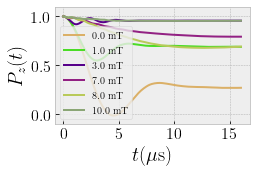

In [5]:
fig, axes = plt.subplots(1,1)
for i, Bmod in enumerate(LongitudinalFields):
    color = list(np.random.choice(range(256), size=3)/256)
    axes.plot(1e6*tlist, signals[i], label='{} mT'.format(Bmod*1e3), linestyle='-', color=color)
axes.set_ylim((-0.1,1.1))
axes.set_ylabel(r'$P_z(t)$')
axes.set_xlabel(r'$t \mathrm{(\mu s)}$')
plt.legend()
plt.show()

## Exact solution

This takes a long time and requires quite a lot of memory!
Results have been stored for comparison.
Set `RUN_EXACT_SOLUTION` to True to recompute it.

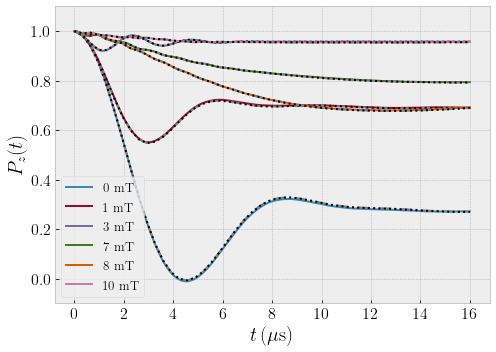

In [6]:
RUN_EXACT_SOLUTION = False
steps = 50
exact_tlist = np.linspace(0, 16e-6, steps)
#exact_signals = np.zeros([6,steps], dtype=np.float)
# Time Interval between 0 and 16 us, 50 steps, LongitudinalFields = (0.0, 0.001, 0.003, 0.007, 0.008, 0.01)
exact_signals = np.array([[ 1.        ,  0.98282653,  0.93964818,  0.8727281 ,  0.78028361,
         0.67469059,  0.56109296,  0.44254458,  0.33016254,  0.22835089,
         0.14071887,  0.07266857,  0.02508912, -0.00138344, -0.00777295,
         0.00332417,  0.02902002,  0.06492124,  0.10737172,  0.15200355,
         0.19525238,  0.23504429,  0.26796097,  0.29364225,  0.31249597,
         0.32294924,  0.32736432,  0.32758011,  0.32305998,  0.3168234 ,
         0.31049457,  0.30331904,  0.29736902,  0.29326092,  0.28955219,
         0.28722038,  0.28623668,  0.28491011,  0.28388694,  0.28322455,
         0.28156636,  0.27978173,  0.27826943,  0.27607753,  0.27416934,
         0.27298859,  0.27164413,  0.27081398,  0.27069118,  0.27024463],
       [ 1.        ,  0.98293689,  0.94103195,  0.87974072,  0.80302765,
         0.72482631,  0.65413908,  0.59895465,  0.56280528,  0.54742553,
         0.55334184,  0.57318891,  0.60218095,  0.63512508,  0.66574397,
         0.69081457,  0.70740053,  0.71651987,  0.71913932,  0.71600087,
         0.71090861,  0.70542094,  0.70019074,  0.69693086,  0.6955793 ,
         0.69528207,  0.69608999,  0.69741402,  0.69823249,  0.69877767,
         0.69893606,  0.69820817,  0.69717636,  0.69597567,  0.69432885,
         0.69276073,  0.69138666,  0.68998791,  0.68896328,  0.68837029,
         0.68798691,  0.68802579,  0.68841152,  0.68882866,  0.68930834,
         0.68973257,  0.68982279,  0.68966208,  0.68929406,  0.68864183],
       [ 1.        ,  0.98379849,  0.95110385,  0.92430074,  0.92333194,
         0.94322695,  0.96888701,  0.98229823,  0.97805614,  0.96199376,
         0.94602602,  0.94102634,  0.94716167,  0.95813592,  0.96467449,
         0.96437462,  0.95925356,  0.95489471,  0.95351849,  0.95495805,
         0.95698291,  0.95811534,  0.95793408,  0.95721899,  0.95668732,
         0.9566025 ,  0.95680559,  0.95701551,  0.95707425,  0.95701427,
         0.9569539 ,  0.95694134,  0.9569614 ,  0.95701089,  0.95704409,
         0.95702411,  0.95701233,  0.9570149 ,  0.95701059,  0.9570523 ,
         0.95710172,  0.95710734,  0.95712119,  0.95711323,  0.95706506,
         0.95704849,  0.95704016,  0.95703239,  0.95707086,  0.95711522],
       [ 1.        ,  0.9875797 ,  0.98140832,  0.98621011,  0.97075648,
         0.95669399,  0.95541905,  0.94319278,  0.92842263,  0.92389329,
         0.91594141,  0.90336002,  0.89654501,  0.89062457,  0.88065119,
         0.87288486,  0.86795318,  0.86108697,  0.85435035,  0.85031619,
         0.84608276,  0.84103892,  0.83743184,  0.83435711,  0.83042769,
         0.82696249,  0.82416836,  0.82088203,  0.81775033,  0.81520849,
         0.81250997,  0.80989694,  0.80777116,  0.80572486,  0.80367457,
         0.80205509,  0.80067282,  0.79915915,  0.7980214 ,  0.79720875,
         0.79614609,  0.79538015,  0.79497777,  0.7942634 ,  0.79376039,
         0.79363704,  0.79320925,  0.79291028,  0.79302161,  0.79286575],
       [ 1.        ,  0.98879191,  0.98699508,  0.98589855,  0.96748469,
         0.96150537,  0.94988836,  0.93042286,  0.92044974,  0.90441159,
         0.88659453,  0.8748919 ,  0.85867707,  0.84326163,  0.8318069 ,
         0.81687864,  0.80418869,  0.79334047,  0.78042514,  0.77008204,
         0.7599696 ,  0.74953374,  0.74097611,  0.73229548,  0.72431931,
         0.71752935,  0.71086347,  0.70512305,  0.70026205,  0.69563065,
         0.69186035,  0.68876905,  0.68581902,  0.68370366,  0.6819059 ,
         0.68029858,  0.67945545,  0.67848443,  0.67807933,  0.67807028,
         0.67782256,  0.67848698,  0.67905924,  0.67970109,  0.68120834,
         0.68242028,  0.68400175,  0.6861668 ,  0.68811348,  0.69043407],
       [ 1.        ,  0.99130363,  0.99367316,  0.98441018,  0.98244009,
         0.97815888,  0.97460671,  0.9757831 ,  0.97160007,  0.9734014 ,
         0.96809696,  0.96718836,  0.9624622 ,  0.95981762,  0.95816497,
         0.95578323,  0.95672477,  0.95537404,  0.95691268,  0.95596032,
         0.95648078,  0.95585914,  0.95559188,  0.95527909,  0.95483432,
         0.95475075,  0.9544889 ,  0.95444332,  0.9543944 ,  0.95427475,
         0.95433552,  0.954215  ,  0.95419628,  0.95416875,  0.95403384,
         0.95404225,  0.9539122 ,  0.9538729 ,  0.95384906,  0.95378848,
         0.95385451,  0.95386919,  0.95395887,  0.95410335,  0.95416793,
         0.95437978,  0.95446006,  0.9546102 ,  0.95474143,  0.9547932 ]]);

exact_signals_CuCu = np.array([[ 1.        ,  0.98282657,  0.93964865,  0.87272935,  0.78028696,
         0.67470233,  0.56111582,  0.4425802 ,  0.33022139,  0.22843251,
         0.14081954,  0.07279242,  0.02522711, -0.00124269, -0.00763999,
         0.00343709,  0.02910163,  0.06495036,  0.10734618,  0.15192438,
         0.19510024,  0.23483281,  0.26770654,  0.29333427,  0.31215187,
         0.3225898 ,  0.32698183,  0.32717626,  0.32264645,  0.31638578,
         0.31001279,  0.30279618,  0.29678455,  0.29258872,  0.2888023 ,
         0.28637759,  0.28528979,  0.28388913,  0.28278938,  0.28205604,
         0.28037023,  0.27855874,  0.27702096,  0.27483837,  0.27292428,
         0.27171386,  0.2703522 ,  0.26946707,  0.26924531,  0.2687014 ],
       [ 1.        ,  0.98293692,  0.9410324 ,  0.87974179,  0.80302961,
         0.72483148,  0.65414674,  0.59895899,  0.56279733,  0.54740125,
         0.55329201,  0.57309325,  0.6020493 ,  0.63496702,  0.6655529 ,
         0.6906192 ,  0.70722795,  0.7163812 ,  0.71905147,  0.71597761,
         0.71095595,  0.70552991,  0.70035639,  0.69714841,  0.6958386 ,
         0.6955805 ,  0.69642111,  0.69777791,  0.69863126,  0.69920142,
         0.69938316,  0.69867854,  0.69765745,  0.69646563,  0.6948309 ,
         0.69326548,  0.6918944 ,  0.69050016,  0.68946443,  0.68884871,
         0.6884322 ,  0.68841465,  0.68872886,  0.68907607,  0.6894854 ,
         0.68985548,  0.68993525,  0.68980003,  0.68950061,  0.68897442],
       [ 1.        ,  0.98379852,  0.95110414,  0.92430114,  0.92333093,
         0.94322128,  0.96888409,  0.9823126 ,  0.9780936 ,  0.96203609,
         0.94603782,  0.94099934,  0.94711532,  0.95810993,  0.96467949,
         0.96440791,  0.95929011,  0.95491137,  0.95350301,  0.95492653,
         0.95696769,  0.95813361,  0.95797172,  0.95724139,  0.9566808 ,
         0.95657913,  0.95678783,  0.95701476,  0.95708748,  0.95702932,
         0.95696214,  0.95694125,  0.95695521,  0.95700292,  0.95703994,
         0.95702566,  0.95701792,  0.95702249,  0.95701571,  0.95705066,
         0.95709516,  0.95709902,  0.95711357,  0.95711164,  0.95707014,
         0.95705628,  0.95704938,  0.95703901,  0.95707135,  0.957112  ],
       [ 1.        ,  0.98757971,  0.98140828,  0.98621163,  0.97076027,
         0.95669799,  0.9554352 ,  0.9432287 ,  0.92846951,  0.92397853,
         0.91606813,  0.90350092,  0.89673768,  0.89084694,  0.88085785,
         0.87312326,  0.86819153,  0.86128541,  0.85455822,  0.85051496,
         0.84625154,  0.8412079 ,  0.83758677,  0.83448791,  0.83054608,
         0.82704993,  0.82422119,  0.82091216,  0.81774283,  0.81516587,
         0.81244542,  0.80980092,  0.80764802,  0.80558272,  0.80350751,
         0.80186382,  0.80046138,  0.79892606,  0.79775734,  0.79691872,
         0.795833  ,  0.79502252,  0.79458771,  0.7938468 ,  0.79329063,
         0.79313491,  0.79268038,  0.79233323,  0.79242035,  0.79224303],
       [ 1.        ,  0.98879192,  0.98699502,  0.98589969,  0.96748394,
         0.96150352,  0.94989131,  0.93041573,  0.92045214,  0.90441505,
         0.8865946 ,  0.87492256,  0.85870154,  0.84331849,  0.8318963 ,
         0.816977  ,  0.80433922,  0.7935124 ,  0.7806272 ,  0.77031396,
         0.76022032,  0.74980401,  0.74125   ,  0.73257968,  0.7245986 ,
         0.71780138,  0.71112593,  0.70537017,  0.70048968,  0.69583262,
         0.69204068,  0.6889101 ,  0.68592623,  0.68377344,  0.68192056,
         0.68027628,  0.67937711,  0.67835476,  0.67790987,  0.67784416,
         0.67756101,  0.67818224,  0.67871672,  0.67932472,  0.68078836,
         0.68197171,  0.68350124,  0.68561896,  0.68751972,  0.68976525],
       [ 1.        ,  0.99130362,  0.99367312,  0.98440939,  0.98243597,
         0.97815107,  0.97458831,  0.97576204,  0.97156735,  0.97337462,
         0.96806425,  0.96718087,  0.96245435,  0.95984159,  0.9581947 ,
         0.95584719,  0.95680812,  0.95550172,  0.9570791 ,  0.95618851,
         0.95675983,  0.95620491,  0.95598891,  0.9557301 ,  0.95532813,
         0.95528609,  0.95505568,  0.95504378,  0.9550178 ,  0.95492921,
         0.95500776,  0.95491351,  0.95491316,  0.95490464,  0.95478939,
         0.95481182,  0.95469816,  0.95467092,  0.95465577,  0.954604  ,
         0.95467099,  0.95468799,  0.95477421,  0.95491163,  0.95497452,
         0.95517234,  0.95525171,  0.95539008,  0.95551605,  0.95556276]])

if RUN_EXACT_SOLUTION:
    LongitudinalFields = (0.0, 0.001, 0.003, 0.007, 0.008, 0.01)
    for idx, Bmod in enumerate(LongitudinalFields):

        # Put field along muon polarization, that is always z
        B = Bmod * np.array([0,0.,1.])
        NS = MuonNuclearInteraction(atoms, external_field=B, log_level='critical')

        # rotate the sumple such that the muon spin is aligned with
        # the 111 direction (and, just for convenience, the muon position is
        # set to (0,0,0) )
        NS.translate_rotate_sample_vec(np.array([1.,1.,1.]))

        print("Computing exact signal for B={}".format(Bmod))
        exact_signals[idx]=NS.polarization(tlist, cutoff=2.0e-10)
        del NS


    exact_signals_CuCu = np.zeros_like(exact_signals)
    for idx, Bmod in enumerate(LongitudinalFields):

        # Put field along muon polarization, that is always z
        B = Bmod * np.array([0,0.,1.])
        NS = MuonNuclearInteraction(atoms, external_field=B, log_level='critical')

        # rotate the sumple such that the muon spin is aligned with
        # the 111 direction (and, just for convenience, the muon position is
        # set to (0,0,0) )
        NS.translate_rotate_sample_vec(np.array([1.,1.,1.]))

        print("Computing exact signal (Cu-Cu interaction) for B={}".format(Bmod))
        exact_signals_CuCu[idx]=NS.polarization(tlist, cutoff=20.0e-10)
        del NS

#import matplotlib as mpl; mpl.style.use(['bmh', 'paper', 'paper_twocol'])
fig, axes = plt.subplots(1,1, figsize=(7,5))

for i, Bmod in enumerate(LongitudinalFields):
    p = axes.plot(1e6*tlist, signals[i], label='{} mT'.format(int(Bmod*1e3)), linestyle='-')
    axes.plot(1e6*exact_tlist, exact_signals[i], linestyle='-.',  color='gray')
    axes.plot(1e6*exact_tlist, exact_signals_CuCu[i], linestyle=':', color='k')

axes.set_ylim((-0.1,1.1))
axes.set_ylabel(r'$P_z(t)$')
axes.set_xlabel(r'$t \, \mathrm{(\mu s)}$')
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig('Cu.png')
plt.show()